### UpGrad Assignment - Advanced Regression
##### Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

Also, **determine the optimal value of lambda for ridge and lasso regression**.

In [1]:
%pip install -q numpy pandas matplotlib scikit-learn seaborn statsmodels jinja2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
if os.name == 'nt':
  !curl.exe -o train.csv https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv
else:
  !wget -P . https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  449k    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  3  449k    3 17050    0     0   7123      0  0:01:04  0:00:02  0:01:02  7127
  7  449k    7 34458    0     0  11450      0  0:00:40  0:00:03  0:00:37 11459
 15  449k   15 69274    0     0  16834      0  0:00:27  0:00:04  0:00:23 16842
 18  449k   18 86682    0     0  16635      0  0:00:27  0:00:05  0:00:22 16640
 18  449k   18 86682    0     0  13953      0  0:00:33  0:00:06  0:00:27 17603
 18  449k   18 86682    0     0  12014      0  0:00:38  0:00:07  0:00:31 14440
 18  449k   18 86682    0     0  10535      0  0:00:43  0:00:08  0:00:35 10008
 18  449k   18 86682    0     0   9392      0  0:00:49  0:00:09  0:00:40  3404
 18  449k   18 86682    0     0   8473      0  0:00

In [12]:
df_data = pd.read_csv('./train.csv')
print(f"Dataset has {df_data.shape[0]} records with {df_data.shape[1]-2} features or columns with 1 target variable 'SalePrice'.\n")
df_data.info()

Dataset has 1460 records with 79 features or columns with 1 target variable 'SalePrice'.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseS

In [13]:
ORDINAL_CATEGORICAL_FEATURES = ['CentralAir', 'MSSubClass', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'PoolQC']
NOMINAL_CATEGORICAL_FEATURES = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']

NUMERICAL_FEATURES = [
    'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

print(f"Out of total {len(ORDINAL_CATEGORICAL_FEATURES) + len(NOMINAL_CATEGORICAL_FEATURES) + len(NUMERICAL_FEATURES)} features there are, \
      \n- {len(ORDINAL_CATEGORICAL_FEATURES)} Categorical Ordinal Featrues \
      \n- {len(NOMINAL_CATEGORICAL_FEATURES)} Categorical Nominal Featrues \
      \n- {len(NUMERICAL_FEATURES)} Numerical Featrues")

Out of total 79 features there are,       
- 21 Categorical Ordinal Featrues       
- 25 Categorical Nominal Featrues       
- 33 Numerical Featrues


### Data Quality Checks

- Identify missing values and treat them.

In [14]:
# Identify columns with null values
for column in list(df_data[NUMERICAL_FEATURES].columns[df_data[NUMERICAL_FEATURES].isna().any()]):
  print(f"{column}: {df_data[column].isna().sum()}")

LotFrontage: 259
MasVnrArea: 8
GarageYrBlt: 81


In [16]:
# OneHotEncoding is throwing error when data is null or NaN.
for feature in NOMINAL_CATEGORICAL_FEATURES:
    if df_data[feature].isna().sum() > 0:
        df_data.loc[df_data[feature].isna(), feature] = 'NA'

#### Univariate Analysis: Numerical features

When dealing with numerical variables, we have to check their properties like:

- Mean
- Median
- Standard Deviation
- Kurtosis/skewness
- distribution/range

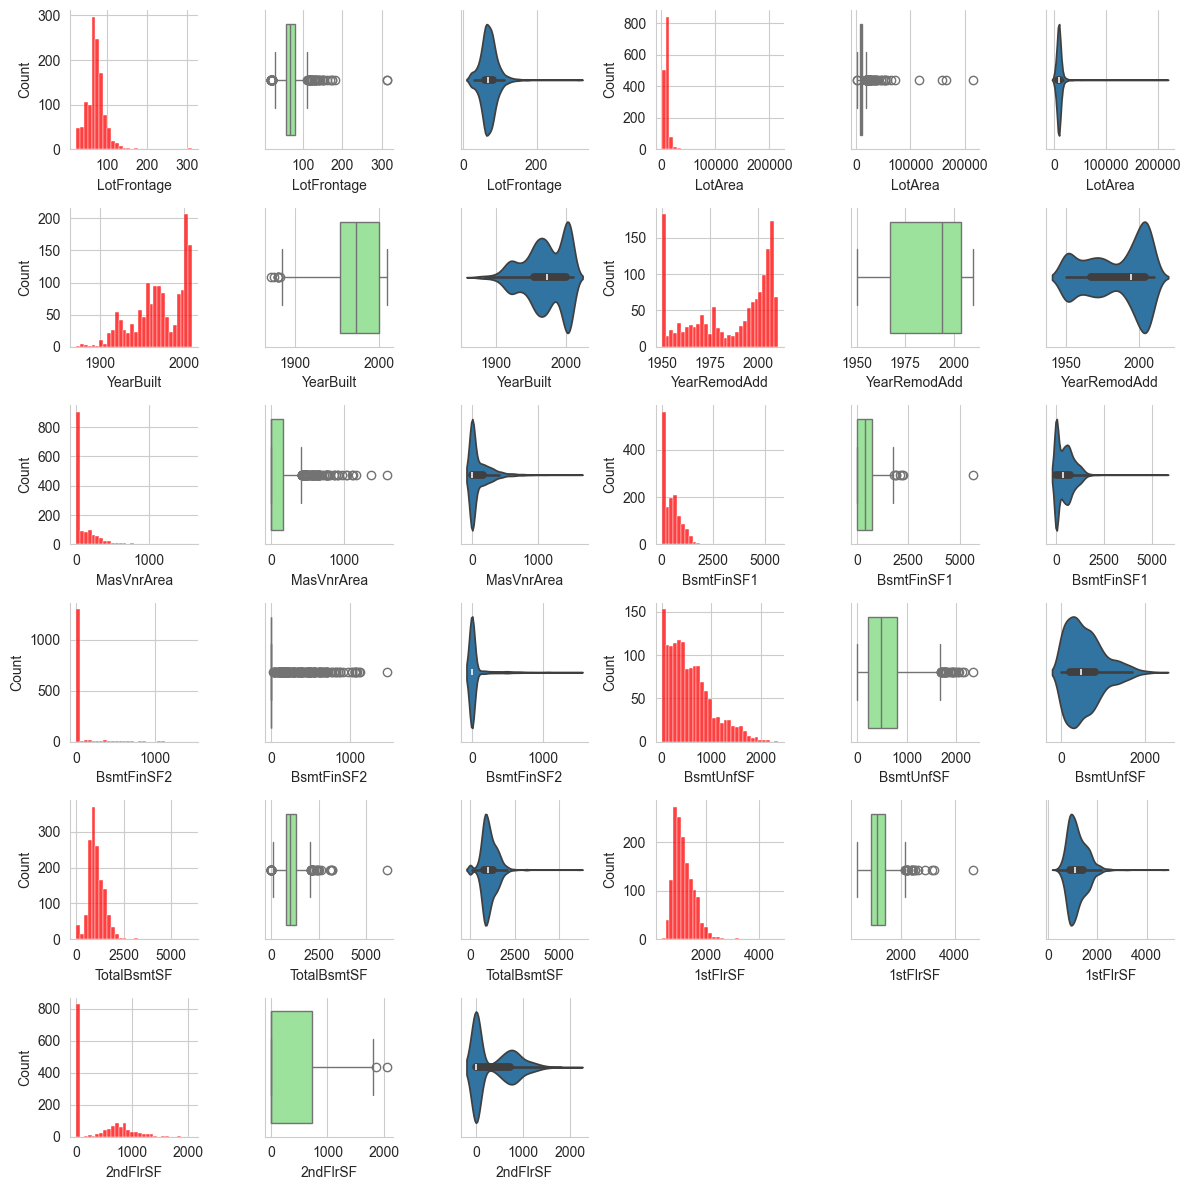

In [17]:
sns.set_style('whitegrid')

num_plots_in_a_row = 6   # No. of plots in every row
num_of_plot_rows = math.ceil(len(NUMERICAL_FEATURES)/num_plots_in_a_row)   # No. of plots in y direction

grid = sns.FacetGrid(pd.DataFrame(NUMERICAL_FEATURES), col=0, col_wrap=6, height=2, sharex=False, sharey=False)
for i, feature in enumerate(NUMERICAL_FEATURES):
    # If not enough features, move on.
    if i*3 >= len(grid.axes):
        break
    axes = sns.histplot(df_data, x=feature, kde = False, color ='red', bins=30, ax=grid.axes[i*3 + 0])
    axes.set_title(None)
    axes = sns.boxplot(df_data, x=feature, color ='lightgreen', ax=grid.axes[i*3 + 1])
    axes.set_title(None)
    axes = sns.violinplot(data=df_data, x=feature, ax=grid.axes[i*3 + 2])
    axes.set_title(None)

grid.tight_layout()
plt.show()


#### Summary of Univariate Analysis: Numerical Features

- `` has outliers.
- `` 

##### Univariate Analysis: Categorical Features

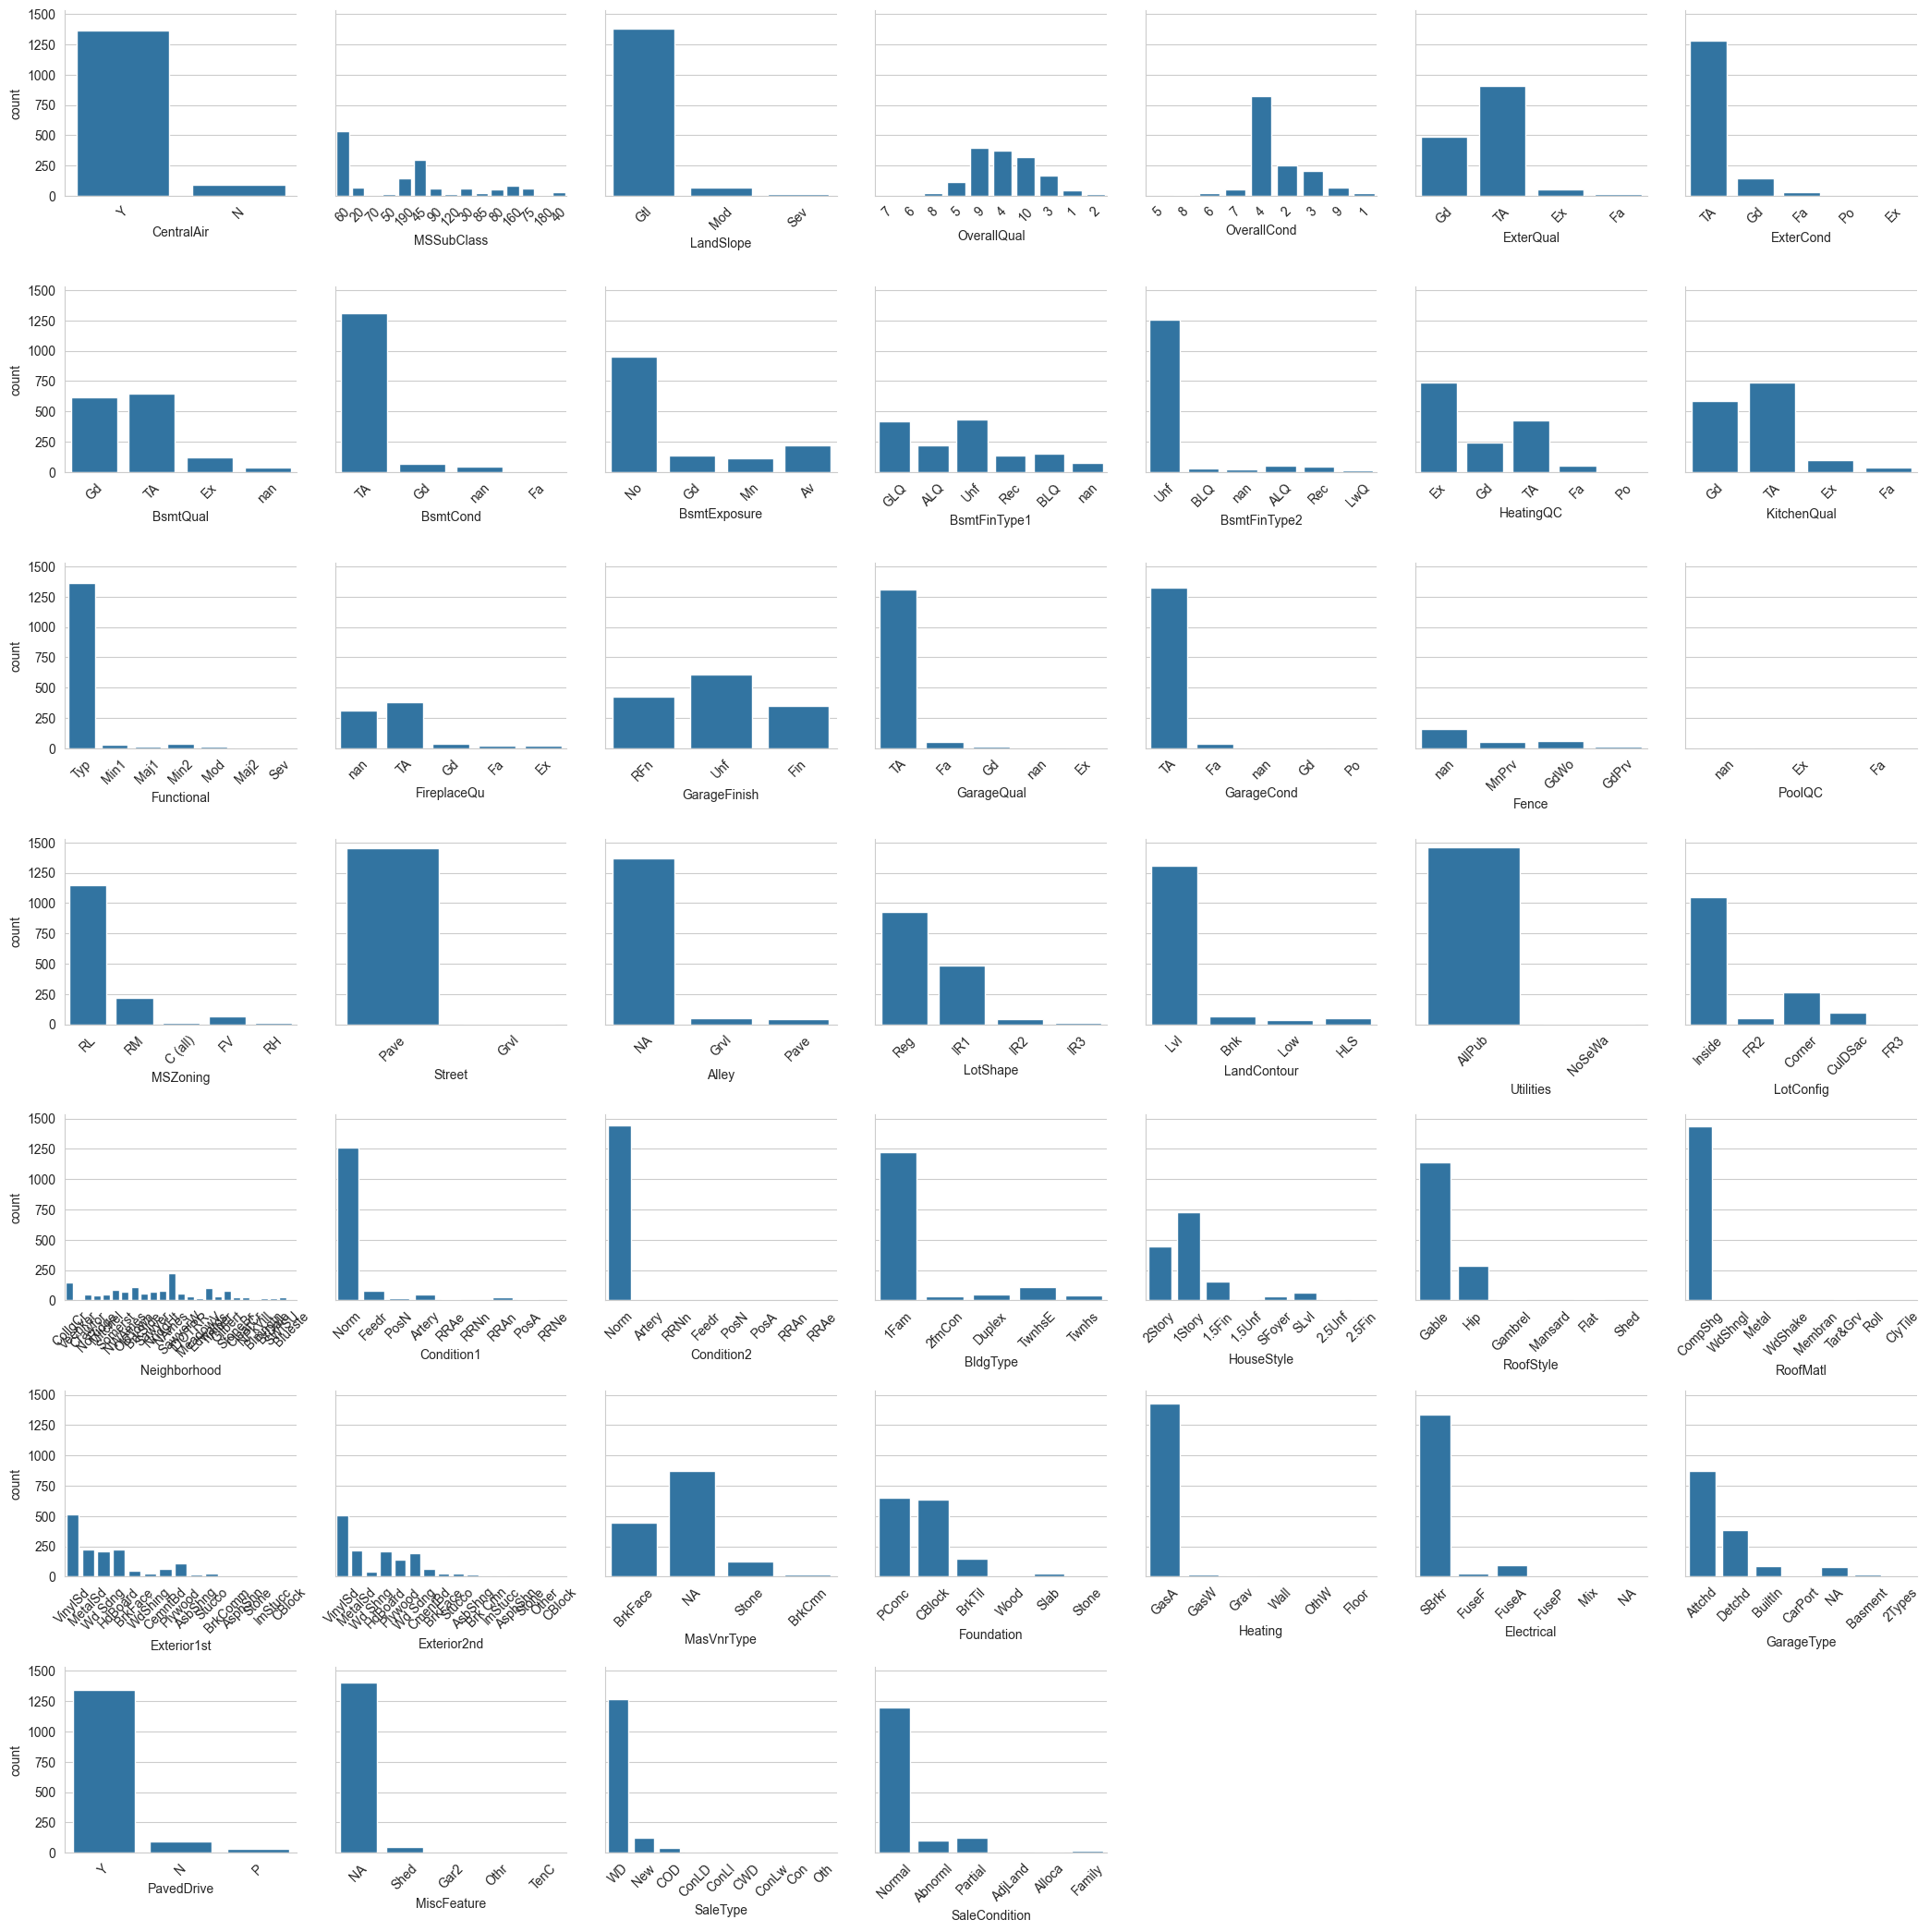

In [18]:
import warnings
warnings.filterwarnings('ignore')

num_plots_in_a_row = 7   # No. of plots in every row
num_of_plot_rows = math.ceil(len(list(ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES))/num_plots_in_a_row)   # No. of plots in y direction

grid = sns.FacetGrid(pd.DataFrame(list(ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES)), col=0, col_wrap=7, height=3, sharey=True, sharex=False, margin_titles=False)
for axs, feature in zip(grid.axes, list(ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES)):
    axes = sns.countplot(df_data, x=feature, ax=axs)
    axes.set_title(None)
    axes.set_xticklabels(labels=df_data[feature].unique(), rotation=45)

grid.tight_layout()
plt.show()

#### Summary of Univariate Analysis: Categorical Features



#### Bivariate Analysis

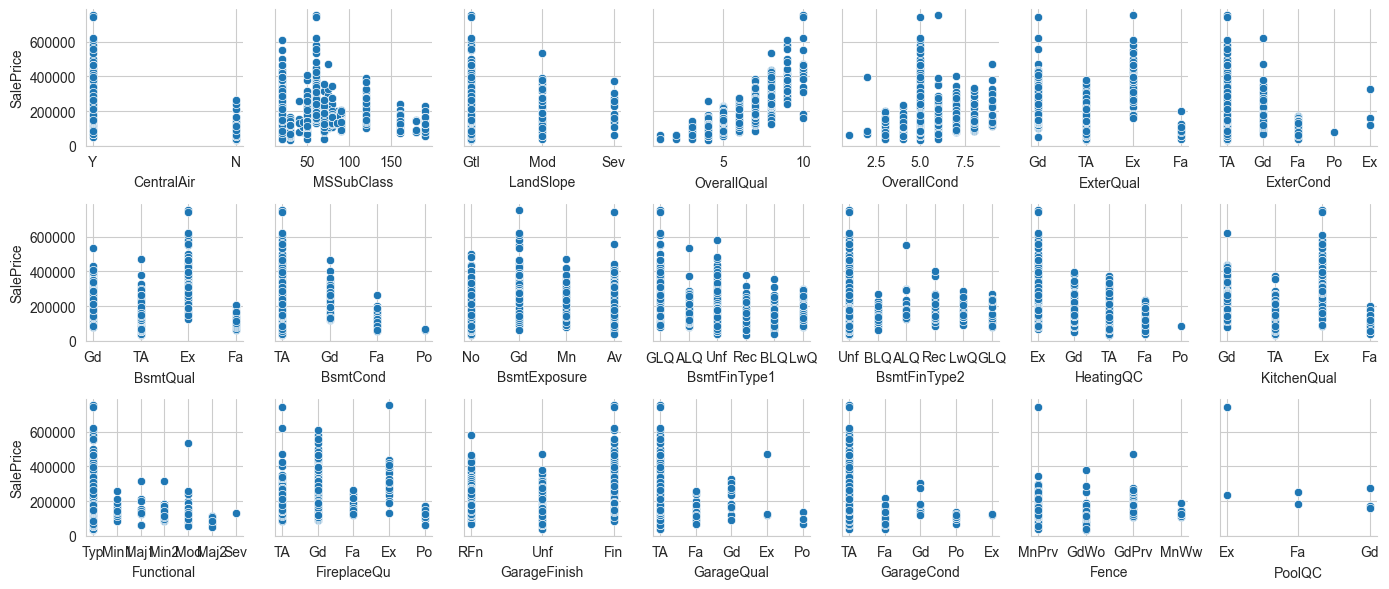

In [19]:
num_plots_in_a_row = 7   # No. of plots in every row
num_of_plot_rows = math.ceil(len(ORDINAL_CATEGORICAL_FEATURES)/num_plots_in_a_row)   # No. of plots in y direction

grid = sns.FacetGrid(pd.DataFrame(ORDINAL_CATEGORICAL_FEATURES), col=0, col_wrap=7, height=2, sharex=False)
for ax, feature in zip(grid.axes, ORDINAL_CATEGORICAL_FEATURES):
    axes = sns.scatterplot(data=df_data, x=feature, y='SalePrice', ax=ax)
    axes.set_title(None)
    
grid.tight_layout()
plt.show()

#### Multivariate Analysis

*Multicollinearity* Checks - Draw Heatmap to check for multicollinearity and relationship between two variables


<Axes: >

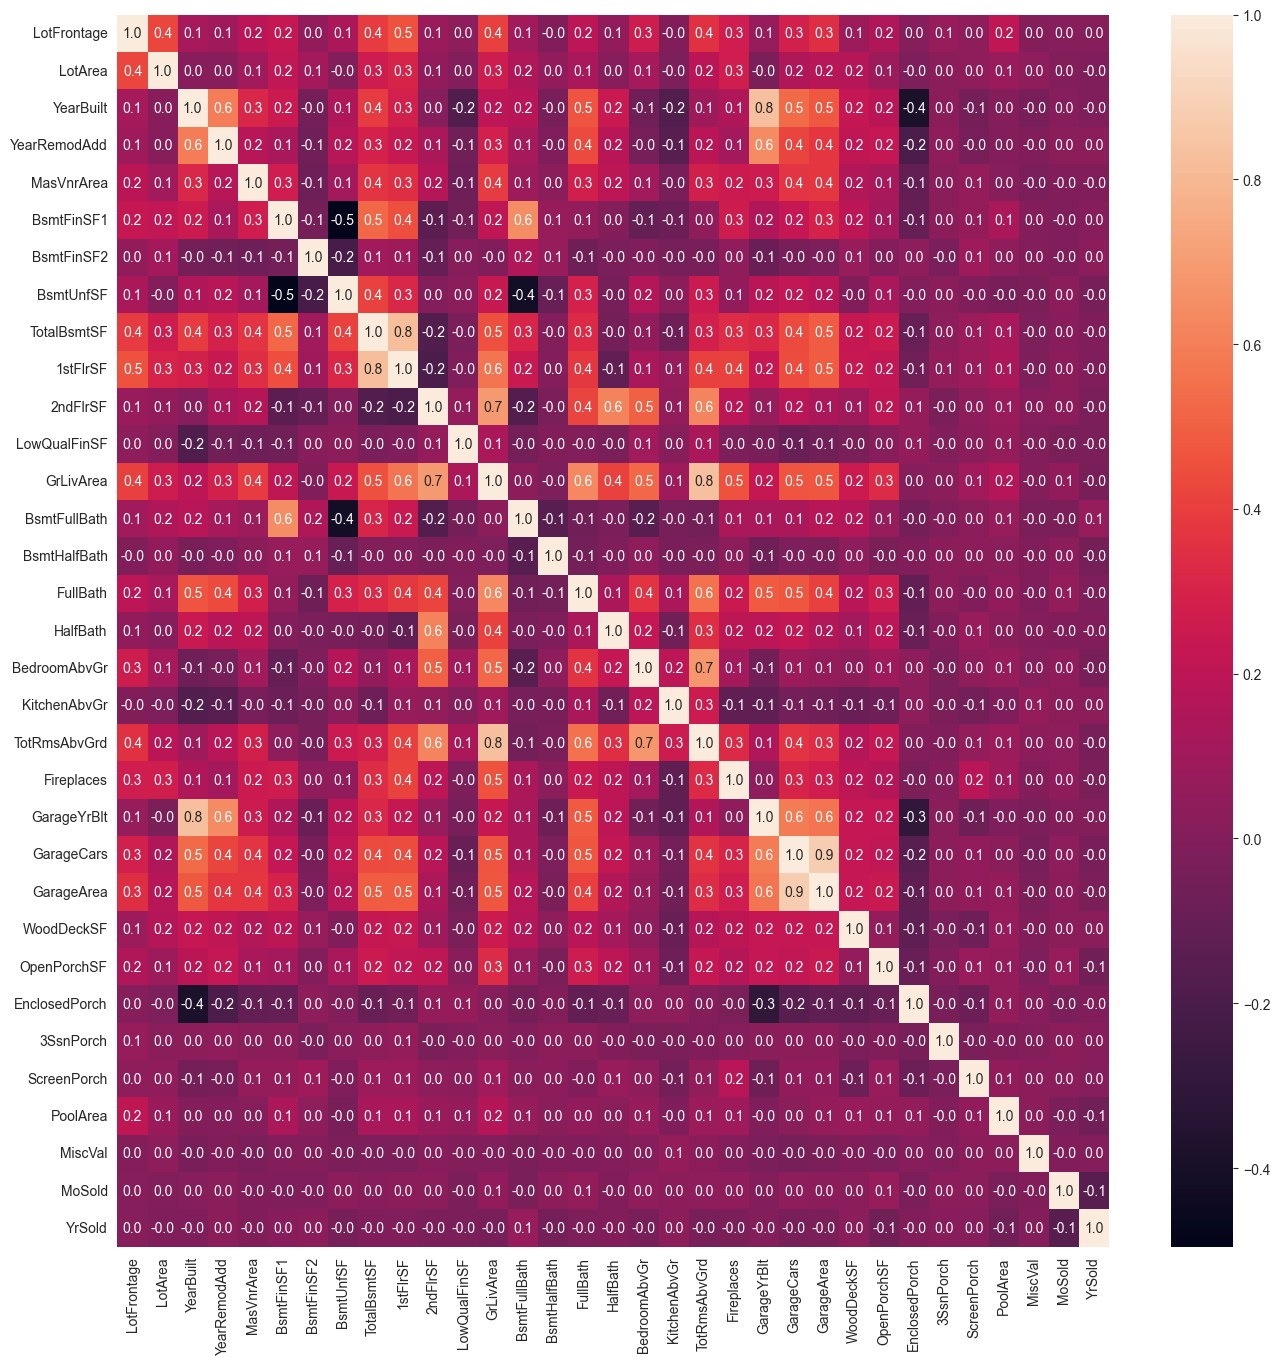

In [20]:
plt.figure(figsize=(16, 16))
sns.heatmap(df_data[NUMERICAL_FEATURES].corr(), annot=True, fmt=".1f")

#### Feature Engineering



#### Scaling Numerical Features

There are two common ways of rescaling:
- Min-Max scaling
- Standardisation (mean-0, sigma-1)

We will be using standardization here.

#### Encoding Category Features
- Encode Categorical Variable through One-hot Encoding
- One hot encoding: One hot encoding utilises N binary variables for N categories in a variable. 

In [22]:
# Creates category names/description columns for analysis.
ordinal_values_by_feature = {
   'CentralAir': {'Y': 1, 'N': 0},
   'LandSlope': {'Gtl':2, 'Mod':1, 'Sev':0},
   'ExterQual' : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'BsmtQual': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
   'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
   'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,'NA': 0},
   'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,'NA': 0},
   'HeatingQC':  {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
   'KitchenQual':  {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
   'Functional': {'Typ':7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0},
   'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
   'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NA': 0},
   'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0}
}

for ordinal_category_feature in ordinal_values_by_feature:
   df_data[ordinal_category_feature] = df_data[ordinal_category_feature].map(ordinal_values_by_feature[ordinal_category_feature])

In [23]:
y = df_data['SalePrice']
df_data.drop('SalePrice', axis=1, inplace=True)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numerical_feature_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_feature_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_feature_transformer, NUMERICAL_FEATURES + ORDINAL_CATEGORICAL_FEATURES),
         ('cat', categorical_feature_transformer, NOMINAL_CATEGORICAL_FEATURES)]
    )

In [25]:
column_transformer.set_output(transform='pandas')

# fit the column transformer to the training data
column_transformer.fit(df_data[NUMERICAL_FEATURES + ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES])

# apply the pipeline to the training and test data
X_transformed = column_transformer.transform(df_data)

print(f"Total columns after features are transformed (scaling & encoding): {len(X_transformed.columns)}")

Total columns after features are transformed (scaling & encoding): 213


In [26]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=100)
del X_transformed

### Feature Elimination

Use RFE (Recursive feature elimination) to eliminate unimportant features

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=100) # running RFE
rfe = rfe.fit(X_train, y_train)

In [28]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('num__LotFrontage', False, 98),
 ('num__LotArea', False, 91),
 ('num__YearBuilt', False, 86),
 ('num__YearRemodAdd', False, 100),
 ('num__MasVnrArea', False, 89),
 ('num__BsmtFinSF1', True, 1),
 ('num__BsmtFinSF2', True, 1),
 ('num__BsmtUnfSF', True, 1),
 ('num__TotalBsmtSF', True, 1),
 ('num__1stFlrSF', True, 1),
 ('num__2ndFlrSF', True, 1),
 ('num__LowQualFinSF', True, 1),
 ('num__GrLivArea', True, 1),
 ('num__BsmtFullBath', False, 102),
 ('num__BsmtHalfBath', False, 113),
 ('num__FullBath', False, 107),
 ('num__HalfBath', False, 109),
 ('num__BedroomAbvGr', False, 87),
 ('num__KitchenAbvGr', False, 93),
 ('num__TotRmsAbvGrd', False, 95),
 ('num__Fireplaces', False, 99),
 ('num__GarageYrBlt', False, 103),
 ('num__GarageCars', False, 90),
 ('num__GarageArea', False, 110),
 ('num__WoodDeckSF', False, 108),
 ('num__OpenPorchSF', False, 97),
 ('num__EnclosedPorch', False, 111),
 ('num__3SsnPorch', False, 106),
 ('num__ScreenPorch', False, 104),
 ('num__PoolArea', False, 92),
 ('num__Mi

In [29]:
col = X_train.columns[rfe.support_]
print(f"Important features list: {col}")
print(f"Unimportant features list: {X_train.columns[~rfe.support_]}")

Important features list: Index(['num__BsmtFinSF1', 'num__BsmtFinSF2', 'num__BsmtUnfSF',
       'num__TotalBsmtSF', 'num__1stFlrSF', 'num__2ndFlrSF',
       'num__LowQualFinSF', 'num__GrLivArea', 'cat__MSZoning_C (all)',
       'cat__MSZoning_FV', 'cat__MSZoning_RH', 'cat__MSZoning_RL',
       'cat__MSZoning_RM', 'cat__Alley_Grvl', 'cat__Alley_NA',
       'cat__Alley_Pave', 'cat__LotShape_IR1', 'cat__LotShape_IR2',
       'cat__LotShape_IR3', 'cat__LotShape_Reg', 'cat__LandContour_Bnk',
       'cat__LandContour_HLS', 'cat__LandContour_Low', 'cat__LandContour_Lvl',
       'cat__LotConfig_Corner', 'cat__LotConfig_CulDSac', 'cat__LotConfig_FR2',
       'cat__LotConfig_FR3', 'cat__LotConfig_Inside',
       'cat__Neighborhood_Blmngtn', 'cat__Neighborhood_Blueste',
       'cat__Neighborhood_BrDale', 'cat__Neighborhood_BrkSide',
       'cat__Neighborhood_ClearCr', 'cat__Neighborhood_CollgCr',
       'cat__Neighborhood_Crawfor', 'cat__Neighborhood_Edwards',
       'cat__Neighborhood_Gilbert', '

#### Building model using statsmodel, for the detailed statistics

In [30]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [31]:
lm = sm.OLS(y_train,X_train_rfe).fit() # Running the linear model

In [32]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     53.94
Date:                Sat, 23 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:25:57   Log-Likelihood:                -13859.
No. Observations:                1168   AIC:                         2.789e+04
Df Residuals:                    1081   BIC:                         2.833e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Model Building and Evaluation

Lets predict sale price of house using linear regression.

In [37]:
pd.set_option('display.max_columns', 250)
X_train.describe()

,num__LotFrontage,num__LotArea,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,num__BsmtUnfSF,num__TotalBsmtSF,num__1stFlrSF,num__2ndFlrSF,num__LowQualFinSF,num__GrLivArea,num__BsmtFullBath,num__BsmtHalfBath,num__FullBath,num__HalfBath,num__BedroomAbvGr,num__KitchenAbvGr,num__TotRmsAbvGrd,num__Fireplaces,num__GarageYrBlt,num__GarageCars,num__GarageArea,num__WoodDeckSF,num__OpenPorchSF,num__EnclosedPorch,num__3SsnPorch,num__ScreenPorch,num__PoolArea,num__MiscVal,num__MoSold,num__YrSold,num__MSSubClass,num__OverallQual,num__OverallCond,cat__MSZoning_C (all),cat__MSZoning_FV,cat__MSZoning_RH,cat__MSZoning_RL,cat__MSZoning_RM,cat__Street_Grvl,cat__Street_Pave,cat__Alley_Grvl,cat__Alley_NA,cat__Alley_Pave,cat__LotShape_IR1,cat__LotShape_IR2,cat__LotShape_IR3,cat__LotShape_Reg,cat__LandContour_Bnk,cat__LandContour_HLS,cat__LandContour_Low,cat__LandContour_Lvl,cat__Utilities_AllPub,cat__Utilities_NoSeWa,cat__LotConfig_Corner,cat__LotConfig_CulDSac,cat__LotConfig_FR2,cat__LotConfig_FR3,cat__LotConfig_Inside,cat__Neighborhood_Blmngtn,cat__Neighborhood_Blueste,cat__Neighborhood_BrDale,cat__Neighborhood_BrkSide,cat__Neighborhood_ClearCr,cat__Neighborhood_CollgCr,cat__Neighborhood_Crawfor,cat__Neighborhood_Edwards,cat__Neighborhood_Gilbert,cat__Neighborhood_IDOTRR,cat__Neighborhood_MeadowV,cat__Neighborhood_Mitchel,cat__Neighborhood_NAmes,cat__Neighborhood_NPkVill,cat__Neighborhood_NWAmes,cat__Neighborhood_NoRidge,cat__Neighborhood_NridgHt,cat__Neighborhood_OldTown,cat__Neighborhood_SWISU,cat__Neighborhood_Sawyer,cat__Neighborhood_SawyerW,cat__Neighborhood_Somerst,cat__Neighborhood_StoneBr,cat__Neighborhood_Timber,cat__Neighborhood_Veenker,cat__Condition1_Artery,cat__Condition1_Feedr,cat__Condition1_Norm,cat__Condition1_PosA,cat__Condition1_PosN,cat__Condition1_RRAe,cat__Condition1_RRAn,cat__Condition1_RRNe,cat__Condition1_RRNn,cat__Condition2_Artery,cat__Condition2_Feedr,cat__Condition2_Norm,cat__Condition2_PosA,cat__Condition2_PosN,cat__Condition2_RRAe,cat__Condition2_RRAn,cat__Condition2_RRNn,cat__BldgType_1Fam,cat__BldgType_2fmCon,cat__BldgType_Duplex,cat__BldgType_Twnhs,cat__BldgType_TwnhsE,cat__HouseStyle_1.5Fin,cat__HouseStyle_1.5Unf,cat__HouseStyle_1Story,cat__HouseStyle_2.5Fin,cat__HouseStyle_2.5Unf,cat__HouseStyle_2Story,cat__HouseStyle_SFoyer,cat__HouseStyle_SLvl,cat__RoofStyle_Flat,cat__RoofStyle_Gable,cat__RoofStyle_Gambrel,cat__RoofStyle_Hip,cat__RoofStyle_Mansard,cat__RoofStyle_Shed,cat__RoofMatl_ClyTile,cat__RoofMatl_CompShg,cat__RoofMatl_Membran,cat__RoofMatl_Metal,cat__RoofMatl_Roll,cat__RoofMatl_Tar&Grv,cat__RoofMatl_WdShake,cat__RoofMatl_WdShngl,cat__Exterior1st_AsbShng,cat__Exterior1st_AsphShn,cat__Exterior1st_BrkComm,cat__Exterior1st_BrkFace,cat__Exterior1st_CBlock,cat__Exterior1st_CemntBd,cat__Exterior1st_HdBoard,cat__Exterior1st_ImStucc,cat__Exterior1st_MetalSd,cat__Exterior1st_Plywood,cat__Exterior1st_Stone,cat__Exterior1st_Stucco,cat__Exterior1st_VinylSd,cat__Exterior1st_Wd Sdng,cat__Exterior1st_WdShing,cat__Exterior2nd_AsbShng,cat__Exterior2nd_AsphShn,cat__Exterior2nd_Brk Cmn,cat__Exterior2nd_BrkFace,cat__Exterior2nd_CBlock,cat__Exterior2nd_CmentBd,cat__Exterior2nd_HdBoard,cat__Exterior2nd_ImStucc,cat__Exterior2nd_MetalSd,cat__Exterior2nd_Other,cat__Exterior2nd_Plywood,cat__Exterior2nd_Stone,cat__Exterior2nd_Stucco,cat__Exterior2nd_VinylSd,cat__Exterior2nd_Wd Sdng,cat__Exterior2nd_Wd Shng,cat__MasVnrType_BrkCmn,cat__MasVnrType_BrkFace,cat__MasVnrType_NA,cat__MasVnrType_Stone,cat__Foundation_BrkTil,cat__Foundation_CBlock,cat__Foundation_PConc,cat__Foundation_Slab,cat__Foundation_Stone,cat__Foundation_Wood,cat__Heating_Floor,cat__Heating_GasA,cat__Heating_GasW,cat__Heating_Grav,cat__Heating_OthW,cat__Heating_Wall,cat__Electrical_FuseA,cat__Electrical_FuseF,cat__Electrical_FuseP,cat__Electrical_Mix,cat__Electrical_NA,cat__Electrical_SBrkr,cat__GarageType_2Types,cat__GarageType_Attchd,cat__GarageType_Basment,cat__GarageType_BuiltIn,cat__GarageType_CarPort,cat__GarageType_Detchd,cat__

In [40]:
lm = LinearRegression()

# Fit a line (data)
lm.fit(X_train, y_train)

LinearRegression()

In [41]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-72472717356448.5
[ 1.83147138e+03  4.95205617e+03  1.28819394e+04  1.41341680e+03
  7.38152130e+03 -3.78717823e+14 -1.33950317e+14 -3.66901100e+14
  3.64275862e+14  1.71011632e+14  1.93103486e+14  2.15089918e+13
 -2.32452426e+14  1.52941286e+03  8.03653814e+01 -1.13264917e+03
 -3.58170925e+02 -6.96243501e+03 -3.87726208e+03  3.02281928e+03
  1.88053441e+03  1.22258546e+03  5.76482588e+03  3.14856892e+02
  7.14980173e+02  2.07050150e+03 -1.72260860e+02  1.27739646e+03
  1.47796438e+03  4.44713036e+03  1.81952673e+03 -1.30282522e+03
 -1.05405015e+02 -3.31132812e+03  1.32030430e+04  7.32981250e+03
  1.58922755e+13  1.58922756e+13  1.58922755e+13  1.58922755e+13
  1.58922755e+13  6.26177482e+12  6.26177484e+12 -2.84529898e+13
 -2.84529898e+13 -2.84529898e+13 -1.68175228e+13 -1.68175227e+13
 -1.68175227e+13 -1.68175228e+13 -4.67604622e+12 -4.67604621e+12
 -4.67604622e+12 -4.67604621e+12 -1.42821462e+13 -1.42821462e+13
  4.31950782e+13  4.31950782e+13  4.31950782e+13  4.31950782e+13
  4.319

#### Residual Analysis of the train data
Check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

Text(0.5, 0, 'Errors')

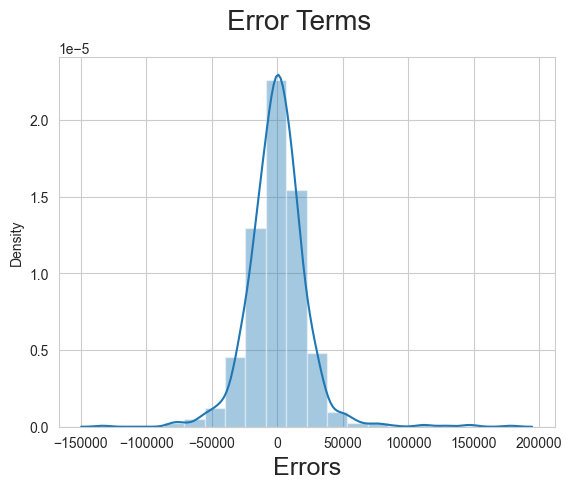

In [42]:

y_pred_train = lm.predict(X_train)

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

In [43]:
from sklearn.metrics import r2_score, mean_squared_error

def calculate_metrics(model):

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metric = []
    r2_train_lr = r2_score(y_train, y_pred_train)
    print(f"Train R2 Score: {r2_train_lr}")
    metric.append(r2_train_lr)

    r2_test_lr = r2_score(y_test, y_pred_test)
    print(f"Test R2 Score: {r2_test_lr}")
    metric.append(r2_test_lr)

    rss1_lr = np.sum(np.square(y_train - y_pred_train))
    print(f"Train Residual Square Sum (RSS)): {rss1_lr}")
    metric.append(rss1_lr)

    rss2_lr = np.sum(np.square(y_test - y_pred_test))
    print(F"Test Residual Square Sum (RSS): {rss2_lr}")
    metric.append(rss2_lr)

    mse_train_lr = mean_squared_error(y_train, y_pred_train)
    print(f"Train Mean Square Error: {mse_train_lr}")
    metric.append(mse_train_lr**0.5)

    mse_test_lr = mean_squared_error(y_test, y_pred_test)
    print(f"Test Mean Square Error: {mse_test_lr}")
    metric.append(mse_test_lr**0.5)

    return metric

In [44]:
metric1 = calculate_metrics(lm)

Train R2 Score: 0.9188320291396067
Test R2 Score: -849238924265913.1
Train Residual Square Sum (RSS)): 594968936052.8806
Test Residual Square Sum (RSS): 1.5942714175493922e+27
Train Mean Square Error: 509391212.3740416
Test Mean Square Error: 5.459833621744494e+24


**Too much variance in R2 Score across train and test dataset.** May be model is overfitting to train data, needs regularization.

### Ridge and Lasso Regression

Lets predict sale price of house using Linear Regression ????

In [45]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [46]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 50}


In [47]:
# Fitting Ridge model for alpha and printing coefficients which have been penalised
alpha = 50
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.45590087e+03  3.11301123e+03  5.61960024e+03  2.10829460e+03
  7.72287256e+03  4.04255999e+03  4.24214982e+02 -6.46944444e+02
  3.70721412e+03  6.81272375e+03  1.01079497e+04 -6.03241256e+02
  1.33530989e+04  5.81146469e+03  9.15510427e+02  2.78817294e+03
  1.67941779e+03 -4.64677260e+03 -2.62780670e+03  5.62223180e+03
  3.79259693e+03  1.11243522e+03  8.36468203e+03  8.10733190e+02
  2.18274480e+03 -3.41826790e+02  5.58475092e+02  1.35286253e+03
  1.45928924e+03 -1.30623773e+03 -2.60513792e+02 -8.60772389e+02
 -6.07045348e+02 -5.13992139e+03  1.89257900e+04  5.84090977e+03
 -2.05359773e+03  2.51549385e+03  1.30733474e+03  2.79063031e+03
 -4.55986118e+03 -7.12775922e+02  7.12775922e+02  2.41015445e+02
  1.42044588e+03 -1.66146133e+03  3.00866130e+03  2.17847551e+03
 -5.16107914e+03 -2.60576842e+01 -8.51947941e+03  3.89587917e+03
  3.34536429e+03  1.27823595e+03  9.88663865e+02 -9.88663865e+02
 -3.76525577e+02  4.03370454e+03 -2.67575325e+03 -5.45189471e+02
 -4.36236251e+02 -2.05248

In [48]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
metric2 = calculate_metrics(ridge)

Train R2 Score: 0.8497139020997481
Test R2 Score: 0.8738936400394309
Train Residual Square Sum (RSS)): 1101611372360.71
Test Residual Square Sum (RSS): 236738754562.05322
Train Mean Square Error: 943160421.5417037
Test Mean Square Error: 810749159.4590864


### Lasso

In [49]:
from sklearn.linear_model import Lasso

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [51]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [52]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha=100

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=100)

In [53]:
lasso.coef_

array([ 6.23789890e+02,  3.59738069e+03,  1.00674737e+04,  1.01068127e+03,
        7.31091364e+03,  8.13826115e+03,  6.75205328e+02, -0.00000000e+00,
        5.88927563e+03,  0.00000000e+00,  1.95311050e+03, -2.67367024e+03,
        2.92626868e+04,  3.25063905e+03,  2.71405063e+02,  3.94944559e+02,
        1.87516706e+00, -6.06472898e+03, -2.99898391e+03,  3.91344002e+03,
        2.64761323e+03,  6.72780434e+02,  6.60604732e+03,  6.84997918e+02,
        1.18883218e+03,  9.28570916e+02, -0.00000000e+00,  9.05614370e+02,
        1.13491854e+03,  2.98306672e+03, -2.21926881e+02, -1.19349668e+03,
       -1.16961542e+01, -3.78562812e+03,  1.56159338e+04,  7.48762757e+03,
       -1.23015702e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.44204815e+03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -7.00199736e+01,  1.83903055e+02,  0.00000000e+00,
       -0.00000000e+00, -4.58434180e+02, -6.90999062e+03,  4.81225005e+03,
        0.00000000e+00, -

In [54]:
metric3 = calculate_metrics(lasso)

Train R2 Score: 0.9028055898807077
Test R2 Score: 0.8719654832532753
Train Residual Square Sum (RSS)): 712444258073.479
Test Residual Square Sum (RSS): 240358472364.53046
Train Mean Square Error: 609969399.0355128
Test Mean Square Error: 823145453.3031865


In [55]:
# Creating a table which contain all the metrics
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric1
        }

lr_metric = pd.DataFrame(lr_table, columns = ['Metric', 'Linear Regression'] )
rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric.style.format(precision=3)

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.919,0.850,0.903
1,R2 Score (Test),-849238924265913.125,0.874,0.872
2,RSS (Train),594968936052.881,1101611372360.710,712444258073.479
3,RSS (Test),1594271417549392189889445888.000,236738754562.053,240358472364.530
4,MSE (Train),22569.697,30710.917,24697.559
5,MSE (Test),2336628687178.280,28473.657,28690.512


## Lets observe the changes in the coefficients after regularization

In [56]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns

betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [57]:
pd.set_option('display.max_rows', None)
betas.head(68)

,Linear,Ridge,Lasso
num__LotFrontage,1.831471e+03,-1455.900867,623.789890
num__LotArea,4.952056e+03,3113.011225,3597.380686
num__YearBuilt,1.288194e+04,5619.600245,10067.473735
num__YearRemodAdd,1.413417e+03,2108.294602,1010.681275
num__MasVnrArea,7.381521e+03,7722.872565,7310.913637
num__BsmtFinSF1,-3.787178e+14,4042.559987,8138.261152
num__BsmtFinSF2,-1.339503e+14,424.214982,675.205328
num__BsmtUnfSF,-3.669011e+14,-646.944444,-0.000000
num__TotalBsmtSF,3.642759e+14,3707.214118,5889.275634
num__1stFlrSF,1.710116e+14,6812.723747,0.000000
